In [1]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import seed_everything

from imuposer.config import Config, amass_combos
from imuposer.models.utils import get_model
from imuposer.datasets.utils import get_datamodule
from imuposer.utils import get_parser

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [64]:
from imuposer.math.angular import r6d_to_rotation_matrix

In [5]:
parser = get_parser()
args = parser.parse_args(["--combo_id", "global", 
                         "--experiment", "IMUPoserGlobalModel-b128"])
combo_id = args.combo_id
fast_dev_run = args.fast_dev_run
_experiment = args.experiment

In [16]:
# !ls ../checkpoints
!ls ../checkpoints/IMUPoserGlobalModel-b128_global-09042023-162745

 best_model.txt
'epoch=epoch=40-val_loss=validation_step_loss=0.01410.ckpt'
'epoch=epoch=42-val_loss=validation_step_loss=0.01403.ckpt'
'epoch=epoch=43-val_loss=validation_step_loss=0.01409.ckpt'
'epoch=epoch=44-val_loss=validation_step_loss=0.01422.ckpt'
'epoch=epoch=47-val_loss=validation_step_loss=0.01407.ckpt'
 wandb


In [17]:
!cat ../checkpoints/IMUPoserGlobalModel-b128_global-09042023-162745/best_model.txt

/root/sumi/sumi_repository/inertial_pose/IMUPoser/checkpoints/IMUPoserGlobalModel-b128_global-09042023-162745/epoch=epoch=42-val_loss=validation_step_loss=0.01403.ckpt

{'/root/sumi/sumi_repository/inertial_pose/IMUPoser/checkpoints/IMUPoserGlobalModel-b128_global-09042023-162745/epoch=epoch=40-val_loss=validation_step_loss=0.01410.ckpt': tensor(0.0141, device='cuda:0'), '/root/sumi/sumi_repository/inertial_pose/IMUPoser/checkpoints/IMUPoserGlobalModel-b128_global-09042023-162745/epoch=epoch=42-val_loss=validation_step_loss=0.01403.ckpt': tensor(0.0140, device='cuda:0'), '/root/sumi/sumi_repository/inertial_pose/IMUPoser/checkpoints/IMUPoserGlobalModel-b128_global-09042023-162745/epoch=epoch=43-val_loss=validation_step_loss=0.01409.ckpt': tensor(0.0141, device='cuda:0'), '/root/sumi/sumi_repository/inertial_pose/IMUPoser/checkpoints/IMUPoserGlobalModel-b128_global-09042023-162745/epoch=epoch=44-val_loss=validation_step_loss=0.01422.ckpt': tensor(0.0142, device='cuda:0'), '/root/sumi/su

In [14]:
checkpoint_dir = "../checkpoints"

In [24]:
model_path = "IMUPoserGlobalModel-b128_global-09042023-162745/epoch=epoch=42-val_loss=validation_step_loss=0.01403.ckpt"

checkpoint = f"{checkpoint_dir}/{model_path}"

In [26]:
config = Config(experiment=f"{_experiment}_{combo_id}", model="GlobalModelIMUPoser",
                project_root_dir="../", joints_set=amass_combos[combo_id], normalize="no_translation",
                r6d=True, loss_type="mse", use_joint_loss=True, device="0") 

In [ ]:
device = "cuda:0"

In [70]:
model = get_model(config).load_from_checkpoint(checkpoint).to(device)
model.eval()

GlobalModelIMUPoser


IMUPoserModel(
  (dip_model): RNN(
    (rnn): LSTM(256, 256, num_layers=2, batch_first=True, bidirectional=True)
    (linear1): Linear(in_features=60, out_features=256, bias=True)
    (linear2): Linear(in_features=512, out_features=144, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (loss): MSELoss()
)

In [32]:
datamodule = get_datamodule(config)
datamodule.setup("test")

Done with setup


In [34]:
data_loader = datamodule.test_dataloader()

In [36]:
for batch in data_loader:
    break

In [55]:
imu_inputs, target_pose, input_lengths, _ = batch

imu_inputs = imu_inputs.to(device)
target_pose = target_pose.to(device)

imu_inputs.shape, target_pose.shape, len(input_lengths)

(torch.Size([128, 300, 60]), torch.Size([128, 300, 144]), 128)

In [127]:
_pred = model(imu_inputs, input_lengths)

In [128]:
pred_pose = _pred[:, :, :model.n_pose_output]
_target = target_pose
target_pose = _target[:, :, :model.n_pose_output]

In [129]:
pred_joint = model.bodymodel.forward_kinematics(pose=r6d_to_rotation_matrix(pred_pose).view(-1, 216))[1]
target_joint = model.bodymodel.forward_kinematics(pose=r6d_to_rotation_matrix(target_pose).view(-1, 216))[1]

In [130]:
pred_joint.shape, target_joint.shape

(torch.Size([38400, 24, 3]), torch.Size([38400, 24, 3]))

In [131]:
# pred_rot, pred_j, pred_v = model.bodymodel.forward_kinematics(pose=r6d_to_rotation_matrix(pred_pose).view(-1, 216), calc_mesh=True)
# target_rot, target_j, target_v =  model.bodymodel.forward_kinematics(pose=r6d_to_rotation_matrix(target_pose).view(-1, 216), calc_mesh=True)
pred_rot, pred_j = model.bodymodel.forward_kinematics(pose=r6d_to_rotation_matrix(pred_pose).view(-1, 216))
target_rot, target_j =  model.bodymodel.forward_kinematics(pose=r6d_to_rotation_matrix(target_pose).view(-1, 216))

In [132]:
import pickle

results = {
    "pred_pose": pred_pose.detach().cpu().numpy(),
    "target_pose": target_pose.detach().cpu().numpy(),
    
    "pred_joint": pred_joint.detach().cpu().numpy(),
    "target_joint": target_joint.detach().cpu().numpy(),
    
    "pred_rot": pred_rot.detach().cpu().numpy(),
    "target_rot": target_rot.detach().cpu().numpy(),
}

with open("predict.pkl", "wb") as f:
    pickle.dump(results, f)

In [133]:
pred_pose_rot = r6d_to_rotation_matrix(pred_pose).reshape(-1, 24, 3, 3)

In [86]:
pred_pose_rot.shape

torch.Size([38400, 24, 3, 3])

In [78]:
import numpy as np
import torch

In [90]:
# # T, J, _  = results["target_joint"].shape
# T, J  = pred_pose_rot.shape[:2]

# T = 100

# # model.bodymodel.view_motion([ pred_joint ], 
# #                             [ torch.zeros((T, 3)).to(device) ] )
# model.bodymodel.view_motion([ pred_pose_rot[:T] ], 
#                             [ torch.zeros((T, 3)).to(device) ] )

In [99]:
model.bodymodel.parent
model.config.pred_joints_set

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [118]:
len(data_loader.dataset.pose)
len(data_loader.dataset.imu)

# data_loader.dataset.imu[0].shape

4600

In [111]:
import matplotlib.pyplot as plt

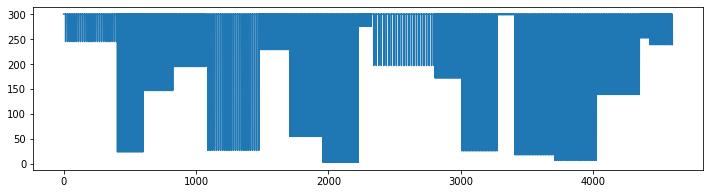

In [117]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot( [len(v) for v in data_loader.dataset.imu ] )
plt.show()

In [143]:
len(data_loader.dataset.imu)
data_loader.dataset.imu[0].shape, data_loader.dataset.pose[0].shape

(torch.Size([300, 60]), torch.Size([300, 216]))

In [141]:
data_loader.dataset.config.r6d

True